# Домашнее задание 4

## Решение треугольных разреженных систем (30 pts)

В этой задаче рассмотрим более детально методы решения треугольных (нижне или верхне) линейных систем при условии, что матрицы этих систем разрежены. С этой задачей вы столкнётесь после того, как выполните разреженное LU разложение и получите желаемые *разреженные* треугольные факторы.

- (5 pts) Реализуйте классический метод решения треугольной линейной системы, однако учтите, что матрица у вас разреженная. Какой формат хранения разреженной матрицы будет предпочтительным для такого метода решения?

- (10 pts) В пункте выше не предполагались никакие специфичные свойства правой части. Однако если предположить, что правая часть является разреженным вектором, то можно предложить более эффективный метод решения такой линейной системы. Основная идея состоит в том, чтобы преобразовать метод из предыдущего пункта из построчного заполнения решения в итерирование по **столбцам** матрицы и соответствующего обновления решения. Какой формат хранения матриы является предпочтительным для такого метода решения? Перепишите метод из предыдущего пункта, так чтобы итерирование происходило по столбцам матрицы, и реализуйте его.

- (15 pts) Дальнейшим развитием является предположение, что помимо разреженной правой части **само решения** также является разреженным. В этом случае можно дополнительно ускорить метод, если рассматривать не все столбцы матрицы, а только те, что действительно влияют на заполненность решения. Для определения таких столбцов необходимо выяснить какие элементы решения окажутся ненулевыми, если в правой части есть ненулевой элемент на позиции $i$? Для ответа на этот вопрос вам поможет графовая интерпретация разреженной матрицы и понятие топологической сортировки. Реализуйте метод решения треугольной разреженной системы в таких предположениях.

- (10 pts) Проведите сравнение реализованных выше методов на разреженных треугольных (верхне и нижне) матрицах и правых частях удовлестворяющих перечисленным выше свойствам. Экспериментально проверьте, в каких случаях, какой метод является предпочтительным. Приведите теоретическую оценку сложности каждого из методов.

## Task 4
Я сразу под методами буду приводить примеры и оценку сложности

In [2]:
# Example of triangular sparse matrix generation
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

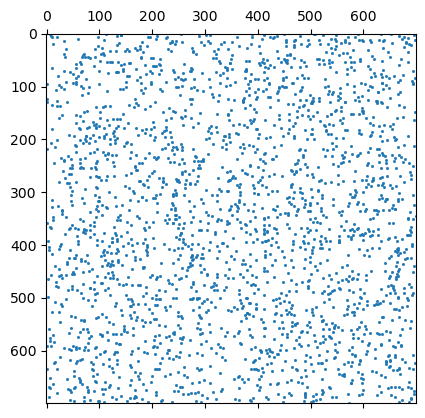

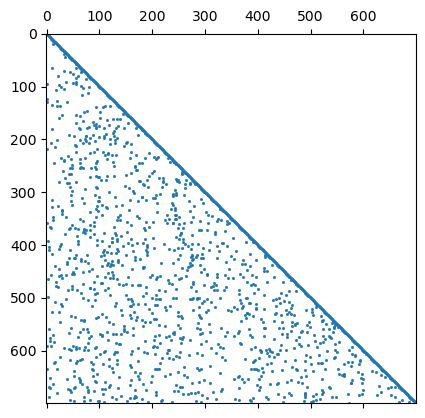

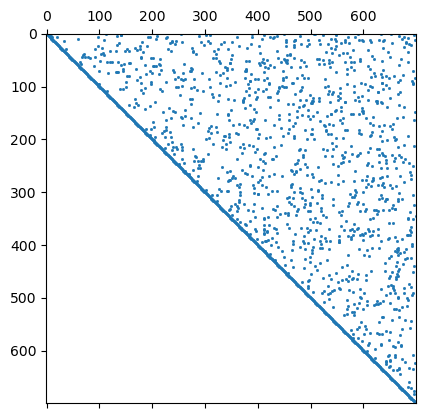

In [3]:
n = 700
A = spsp.rand(n, n, density=0.005).tocsc()
plt.spy(A, markersize=1)
plt.show()
L = spsp.tril(A) + spsp.eye(n)
U = spsp.triu(A) + spsp.eye(n)
plt.spy(L, markersize=1)
plt.show()
plt.spy(U, markersize=1)
plt.show()

## Task 1
- (5 pts) Реализуйте классический метод решения треугольной линейной системы, однако учтите, что матрица у вас разреженная. Какой формат хранения разреженной матрицы будет предпочтительным для такого метода решения?


В данном методе постоянно обращаемся к строкам матрицы $L, U$  
соответсвенно предпочтительным форматом является CSR.  
Сложность данного алгоритма $O(n^2)$

In [8]:
def LU_standart(L, U, b):
    # Ky = b
    y = np.zeros(L.shape[0])
    for i in range(L.shape[0]):
        y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]

    x = np.zeros(U.shape[0])
    for i in range(U.shape[0] - 1, -1, -1):
        x[i] = (y[i] - U[i, i + 1:] @ x[i + 1:]) / U[i, i]

    return x

L = spsp.csr_matrix(L)
U = spsp.csr_matrix(U)

b = np.random.rand(n)
%timeit LU_standart(L, U, b)
x = LU_standart(L, U, b)

101 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


2.9312643606417173e-15

## Task 2

- (10 pts) В пункте выше не предполагались никакие специфичные свойства правой части. Однако если предположить, что правая часть является разреженным вектором, то можно предложить более эффективный метод решения такой линейной системы. Основная идея состоит в том, чтобы преобразовать метод из предыдущего пункта из построчного заполнения решения в итерирование по **столбцам** матрицы и соответствующего обновления решения. Какой формат хранения матриы является предпочтительным для такого метода решения? Перепишите метод из предыдущего пункта, так чтобы итерирование происходило по столбцам матрицы, и реализуйте его.


Итерироваться будем вдоль столбцов матриц, соответсвенно более подходящий формат $CSC$  
Сложность данного на самом деле тоже $O(n^2)$.  
Так как каждая итерация занимает $O(n)$ и необходимо сделать их $O(n)$ (хотя бы для проверки на 0). Можно было бы хранить $b$ в сжатом виде, но $y$ все равно не будет тогда разреженным и итоговая сложность не изменится. 


In [61]:
def LU_bsparse(L, U, b, eps=1e-7):
    y = b.copy()
    for i in range(L.shape[0]):
        if np.abs(y[i]) < eps:
            continue

        y[i + 1:] -= (L[i + 1:, i] * y[i]).toarray().reshape(-1)

        # for j in range(i + 1, L.shape[0]):
        #     if np.abs(L[j, i]) < eps:
        #         continue
                
        #     y[j] = y[j] - L[j, i] * y[i]

    x = y
    for i in range(U.shape[0] - 1, -1, -1):
        if np.abs(x[i]) < eps:
            continue

        x[:i] -= (U[:i, i] * x[i]).toarray().reshape(-1)

        # for j in range(i):
        #     if np.abs(U[j, i]) < eps:
        #         continue
                
        #     x[j] = x[j] - U[j, i] * x[i]

    return x

In [62]:
b = spsp.rand(n, 1, density=0.005).to_dok()
L = spsp.csc_matrix(L)
U = spsp.csc_matrix(U)
%timeit LU_bsparse(L, U, b)

x = LU_bsparse(L, U, b)
np.linalg.norm(L @ U @ x - b)

26.1 ms ± 608 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


2.064115392595114e-16

In [63]:
L = spsp.csr_matrix(L)
U = spsp.csr_matrix(U)
%timeit LU_standart(L, U, b)

x = LU_standart(L, U, b)
np.linalg.norm((L @ U @ x - b))

101 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.8676119449897542e-16

Победили в 4 раза стандартный алгоритм

# Task 3
- (15 pts) Дальнейшим развитием является предположение, что помимо разреженной правой части **само решения** также является разреженным. В этом случае можно дополнительно ускорить метод, если рассматривать не все столбцы матрицы, а только те, что действительно влияют на заполненность решения. Для определения таких столбцов необходимо выяснить какие элементы решения окажутся ненулевыми, если в правой части есть ненулевой элемент на позиции $i$? Для ответа на этот вопрос вам поможет графовая интерпретация разреженной матрицы и понятие топологической сортировки. Реализуйте метод решения треугольной разреженной системы в таких предположениях.